# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


# database = '../data/IoT.db'
# database = '../data/TinyVul.db'
database = "/Users/guru/research/TinyVul-v2.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

KeyboardInterrupt: 

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [ ]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')

dfplt['category'] = dfplt.apply(lambda row: row['category'] 
if row['category']==row['name'] or row['name']=='-' 
else row['name'], axis=1)
dfplt = dfplt.drop(labels=['name'], axis=1)

fig = px.sunburst(dfplt, 
    path=['category', 'cwe'],
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [ ]:
fig.write_image("../figure/vul_statistics.pdf")

In [ ]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,cwe,count
61,memcpy,CWE-120,21153
50,char,CWE-119!/CWE-120,16396
66,sprintf,CWE-120,6036
71,strlen,CWE-126,4565
70,strcpy,CWE-120,2188
63,read,"CWE-120, CWE-20",2087
37,uninitvar,CWE-457,1464
13,integerOverflow,CWE-190,1435
97,open,CWE-362,1282
81,printf,CWE-134,891


# Top 10 vulnerabilities

In [ ]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+-----------------+------------------+---------+
|    | category        | cwe              |   count |
|----+-----------------+------------------+---------|
|  0 | memcpy          | CWE-120          |   21153 |
|  1 | char            | CWE-119!/CWE-120 |   16396 |
|  2 | sprintf         | CWE-120          |    6036 |
|  3 | strlen          | CWE-126          |    4565 |
|  4 | strcpy          | CWE-120          |    2188 |
|  5 | read            | CWE-120, CWE-20  |    2087 |
|  6 | uninitvar       | CWE-457          |    1464 |
|  7 | integerOverflow | CWE-190          |    1435 |
|  8 | open            | CWE-362          |    1282 |
|  9 | printf          | CWE-134          |     891 |
+----+-----------------+------------------+---------+


<AxesSubplot: >

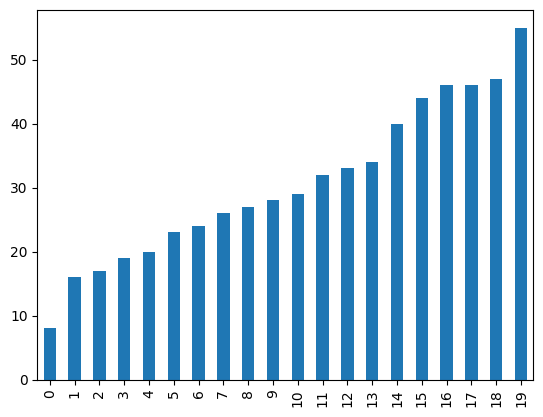

In [ ]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [ ]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 151  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[52, 23, 0, 66, 10]

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [ ]:
# # for project-wise distribution
# projects = list(dfs.project.unique())

# for project in projects:
#     print(project)
#     df = dfs[dfs.project == project]
#     print(df.shape)
#     # print(df.cwe.value_counts())
#     # print(df.category.value_counts())
#     print('----------------------')

## Create a latex table from the statistics of projects

In [ ]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))

In [ ]:
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dff_binary['project'] = dff_binary.project.str.split('/').str[-1]

prj_fun = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_fun.groupby(['project', 'cwe']).sum()
# prj_f['total'] = prj_f.groupby('project').sum()
# prj_f['ratio'] = prj_f['count']/prj_f['total']
prj_f = prj_f.reset_index()
prj_f


,project,cwe,count
0,ARMmbed,Benign,21206
1,ARMmbed,Vulnerable,4889
2,FreeRTOS,Benign,17196
3,FreeRTOS,Vulnerable,3675
4,RIOT,Benign,7583
5,RIOT,Vulnerable,2227
6,contiki,Benign,1730
7,contiki,Vulnerable,568
8,gnucobol,Benign,1941
9,gnucobol,Vulnerable,909


In [ ]:
prj_f = prj_f.rename(columns={'cwe':'cwef', 'count':'#function','project':'projectf'})
prj_stat = prj_stat.rename(columns={'count':'#statement'})

df_dist = pd.concat([prj_stat, prj_f], axis=1, join='inner')
df_dist = df_dist.sort_values(by=['#statement'], ascending=False)
df_dist = df_dist.drop(columns=['projectf', 'cwef'], axis=1)
df_dist = df_dist.set_index(['project', 'cwe']).unstack()
df_dist = df_dist.append(df_dist.sum().rename('TOTAL'))
df_dist.reset_index().to_latex('../result/project-stat.tex', index=False, )
# df_dist.append(df_dist.sum().tolist(), ignore_index=True)
df_dist

#statement            #function           
cwe             Benign Vulnerable    Benign Vulnerable
project                                               
ARMmbed          37798       5984     21206       4889
FreeRTOS         37980       4398     17196       3675
RIOT             13349       2357      7583       2227
contiki           3756        977      1730        568
gnucobol          8828       1356      1941        909
linux-rpi       772050      44622    407684      48696
mbed-os          27305         18       216         22
micropython      35440       3662     19005       4126
mosquitto         4139        490       817        558
openwrt           6519        861      3068        677
tinyos            2249        410       944        352
TOTAL           949413      65135    481390      66699

In [ ]:
print(f"Total #statements: {df_dist[-1:].T.reset_index()['TOTAL'][0:2].sum()}")
print(f"Total #functions: {df_dist[-1:].T.reset_index()['TOTAL'][2:4].sum()}")

Total #statements: 1014548
Total #functions: 548089


In [ ]:
37798 + 5984

43782

In [ ]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
# prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [ ]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
# print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

In [ ]:
dff['cwe'] = dff.cwe.str.replace(r"\['|']", "",regex=True)
dfs_cwe = dfs.cwe.value_counts().reset_index(name='#statements')

dff_cwe = dff.cwe.value_counts().reset_index(name='#functions')

dfs_cwe = dfs_cwe.rename(columns={'index':'cwe'})
dff_cwe = dff_cwe.rename(columns={'index':'cwe'})
df_cwe_count = pd.concat([dfs_cwe, dff_cwe], axis=1).head(10)
df_cwe_count = df_cwe_count.astype({"#functions": int})
df_cwe_count.to_latex('../result/cwe-top-10.tex', index=False)
df_cwe_count

,cwe,#statements,cwe,#functions
0,Benign,949413,Benign,481390
1,CWE-120,30953,CWE-120,28119
2,CWE-119!/CWE-120,16408,CWE-119!/CWE-120,12014
3,CWE-126,4630,CWE-126,5503
4,CWE-190,2303,CWE-unknown,5008
5,"CWE-120, CWE-20",2256,CWE-457,4785
6,CWE-362,1794,CWE-190,2550
7,CWE-134,1689,"CWE-120, CWE-20",2496
8,CWE-457,1648,CWE-362,2277
9,CWE-362/CWE-367!,598,CWE-134,1116


# Show the description of the function-level data

In [ ]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)

# shortening the project URL to project name only 
df_freq['top'] = df_freq.apply(lambda row:row['top'].split('/')[-1] if '/' in row['top'] else row['top'], axis=1)

# The freq is the most common value’s frequency. The top is the most common value.
print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False,
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &       top &   freq \\
\midrule
 context &  46197 &           & 481390 \\
     cwe &      2 &    Benign & 481390 \\
 project &     11 & linux-rpi & 456380 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 1014548
Size of unique statements: 1014205

Size of functions: 548089
Size of unique functions: 539365


# ML-specific: Convert hyperparameters list to latex table format

In [ ]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config/classifier.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
 hyperparameter &                    value \\
\midrule
         epochs &                      120 \\
   debug\_epochs &                        5 \\
          batch &                      128 \\
   input\_length &                      150 \\
      input\_dim &                      150 \\
     output\_dim &                       32 \\
             lr &                     1e-3 \\
       patience &                       35 \\
      optimizer &                     adam \\
         l2\_reg &                     1e-4 \\
        dropout &                     0.01 \\
  recur\_dropout &                     0.01 \\
         beta\_1 &                     0.09 \\
         beta\_2 &                   0.0999 \\
        epsilon &                    1e-08 \\
          decay &                      0.0 \\
        verbose &                        2 \\
loss\_multiclass & c

# tokens count of function-level data

In [ ]:
from gensim.utils import simple_preprocess

fun_token_count = [len(simple_preprocess(x)) for x in dff.code]
stat_token_count = [len(simple_preprocess(x)) for x in dfs.context]

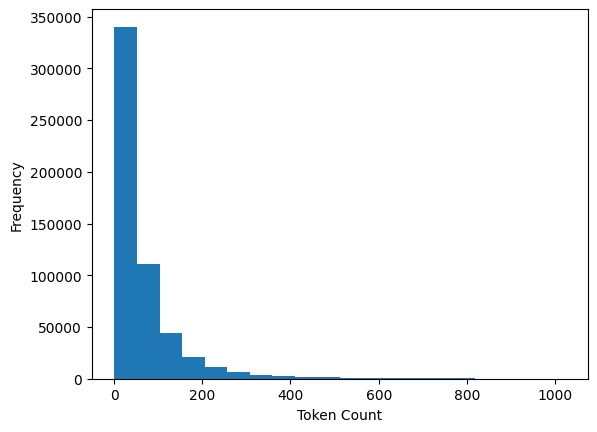

In [ ]:
fun_token_count_short = [x for x in fun_token_count if x<=1024]
pd.Series(fun_token_count_short).plot.hist(bins=20)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
# plt.title('Function Token Count Distribution')
plt.savefig('../figure/fun_token_count.pdf')

In [ ]:
pd.Series(stat_token_count).describe()

3.342422438366642

In [ ]:
pd.Series(fun_token_count).describe()

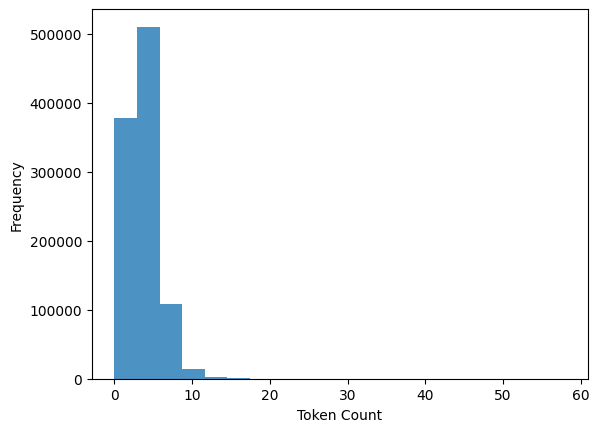

In [ ]:
pd.Series(stat_token_count).plot.hist(bins=20, alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
plt.savefig('../figure/stat_token_count.pdf')

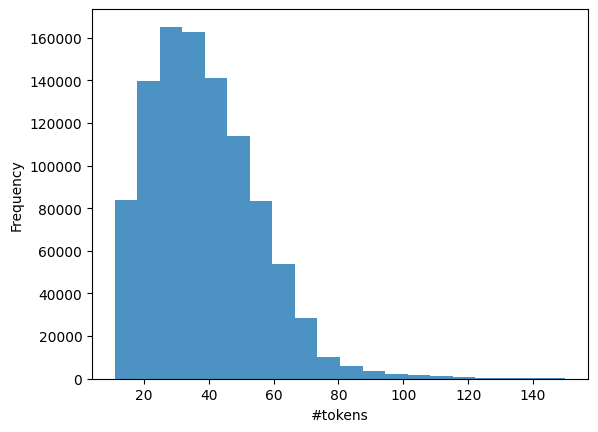

In [ ]:
dfs1 = dfs[dfs.context.str.len()<151]
stat_char_len = [len(x) for x in dfs1.context if len(x)>10]
ax = pd.Series(stat_char_len).plot.hist(bins=20, xlabel='#chars', ylabel='#statements',alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
fighist = ax.get_figure()
fighist.savefig('../figure/statement-charlen.pdf')

In [ ]:
pd.Series(stat_char_len).describe()

count    998488.000000
mean         38.375010
std          16.891746
min          11.000000
25%          26.000000
50%          36.000000
75%          49.000000
max         150.000000
dtype: float64

In [ ]:
dff.describe().T

,count,unique,top,freq
file,548089,23263,/Users/guru/research/projects/FreeRTOS/FreeRTO...,1487
code,548089,539365,static struct syscall *trace__syscall_info(str...,9
context,548089,46197,,481390
cwe,548089,40,Benign,481390
project,548089,11,/Users/guru/research/projects//linux-rpi,456380
